## Regenerate and scale up user data with interaction label

In [1]:
import os
import random
import csv

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

PT_PATH = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
OUTPUT_CSV = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user_100000.csv"
NUM_USERS = 100_000
TRAINERS_PER_USER = 18
VIDEO_COUNT = 5
ALPHA = 0.05
P_MAX = 0.95

# load trainer data
df = pd.read_csv(PT_PATH)

# convert columns to numeric and fill missing with zero
for col in ['athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience', 'videos_count']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# apply log transform and min–max scaling for skewed columns
log_cols = ['total_likes', 'videos_count']
for col in log_cols:
    df[f'norm_{col}'] = MinMaxScaler().fit_transform(np.log1p(df[[col]]))

# apply min–max scaling for other columns
scale_cols = ['workout_recommendations', 'athlete_rating', 'years_experience']
for col in scale_cols:
    df[f'norm_{col}'] = MinMaxScaler().fit_transform(df[[col]])

# compute a single score via PCA on the normalized features
features = [f'norm_{c}' for c in log_cols + scale_cols]
pca = PCA(n_components=1).fit(df[features])
weights = np.abs(pca.components_[0])
weights /= weights.sum()
df['score'] = df[features].dot(weights)

# split the specialties string into a list
df['specialities'] = df['specialities'].astype(str)
df['speciality_list'] = df['specialities'].str.split(',').apply(lambda lst: [s.strip() for s in lst])

def sample_with_fair_direction(layer_df, k, used, seed):
    """
    randomly shuffle the layer, pick k trainers
    preferring new specialties, then fill remaining slots
    """
    shuffled = layer_df.sample(frac=1, random_state=seed)
    picked = []
    for _, row in shuffled.iterrows():
        dirs = set(row['speciality_list'])
        if not dirs & used:
            picked.append(row)
            used |= dirs
        if len(picked) == k:
            break
    if len(picked) < k:
        for _, row in shuffled.iterrows():
            if row['trainer_id'] not in [t['trainer_id'] for t in picked]:
                picked.append(row)
                if len(picked) == k:
                    break
    return picked, used

def generate_recommendations(all_df, user_id):
    """
    split trainers into three tiers by score
    pick a few from each tier to balance quality and diversity
    """
    sorted_df = all_df.sort_values('score', ascending=False).reset_index(drop=True)
    third = len(sorted_df) // 3
    tiers = [
        sorted_df.iloc[:third],
        sorted_df.iloc[third:2*third],
        sorted_df.iloc[2*third:]
    ]
    per_tier = TRAINERS_PER_USER // 3
    used_dirs = set()
    recommendations = []
    for i, tier in enumerate(tiers):
        seed = abs(hash(f"{user_id}_{i}")) % (2**32)
        picked, used_dirs = sample_with_fair_direction(tier, per_tier, used_dirs, seed)
        recommendations.extend(picked)
    # remove duplicates
    seen = set()
    unique = []
    for row in recommendations:
        tid = row['trainer_id']
        if tid not in seen:
            seen.add(tid)
            unique.append(row)
    return unique

def compute_overlap(goals, specs):
    """
    compute overlap count, jaccard score, and if any match exists
    """
    G = set(goals.split(', '))
    S = set(specs)
    I = G & S
    U = G | S
    overlap_count = len(I)
    jaccard = len(I) / len(U) if U else 0.0
    direction_match = int(bool(I))
    return overlap_count, jaccard, direction_match

def construct_label(watched, rated, score_given):
    """
    assign a discrete label based on watch and rating behavior
    """
    if watched == 0:
        return 0
    if rated:
        if score_given >= 5:
            return 5
        if score_given == 4:
            return 4
        if score_given == 3:
            return 3
        return 2
    if watched > 3:
        return 3
    if watched > 1:
        return 2
    return 1

age_groups = ['young', 'middle', 'senior']
genders = ['Male', 'Female']
goal_map = {
    ('young', 'Female'): ['Yoga', 'Pilates', 'WeightLoss', 'HIIT', 'Flexibility', 'StrengthTraining', 'Cardio', 'PrenatalFitness'],
    ('young', 'Male'): ['CrossFit', 'Bodybuilding', 'Powerlifting', 'HIIT', 'Sports-Specific', 'Cardio', 'StrengthTraining'],
    ('middle', 'Female'): ['Pilates', 'Flexibility', 'WeightLoss', 'FunctionalTraining', 'Yoga', 'StrengthTraining'],
    ('middle', 'Male'): ['StrengthTraining', 'FunctionalTraining', 'MuscleBuilding', 'Sports-Specific', 'Cardio', 'HIIT'],
    ('senior', 'Female'): ['ElderlyFitness', 'Flexibility', 'Rehabilitation', 'Cardio', 'Pilates', 'FunctionalTraining'],
    ('senior', 'Male'): ['ElderlyFitness', 'Flexibility', 'Rehabilitation', 'FunctionalTraining', 'Cardio']
}

os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)

with open(OUTPUT_CSV, 'w', newline='') as f:
    writer = None
    for i in range(NUM_USERS):
        user_id = 10001 + i
        age_group = random.choice(age_groups)
        gender = random.choice(genders)
        goals = random.sample(goal_map[(age_group, gender)], k=random.choices([1, 2], [0.6, 0.4])[0])
        user_goals = ', '.join(goals)

        recs = generate_recommendations(df, user_id)
        for t in recs:
            overlap_count, jaccard, direction_match = compute_overlap(user_goals, t['speciality_list'])

            watch_sum = 0
            watch_flags = []
            for _ in range(VIDEO_COUNT):
                prob = min(0.2 + 0.2 * overlap_count + ALPHA * watch_sum, P_MAX)
                watched = int(random.random() < prob)
                watch_flags.append(watched)
                watch_sum += watched

            if watch_sum >= 2:
                rate_prob = min(0.1 + 0.15 * watch_sum + 0.4 * jaccard, P_MAX)
                rated = int(random.random() < rate_prob)
            else:
                rated = 0

            if rated:
                raw = np.random.normal(loc=2.5 + 0.3 * watch_sum + 1.5 * jaccard, scale=1.2)
                score_given = int(np.clip(round(raw), 1, 5))
            else:
                score_given = 0

            label = construct_label(watch_sum, rated, score_given)

            row = {
                'user_id': user_id,
                'age_group': age_group,
                'gender': gender,
                'user_goals': user_goals,
                'trainer_id': t['trainer_id'],
                **{f'watch_v{j+1}': watch_flags[j] for j in range(VIDEO_COUNT)},
                'watched_count': watch_sum,
                'rated': rated,
                'score_given': score_given,
                'overlap_count': overlap_count,
                'jaccard_score': jaccard,
                'direction_match': direction_match,
                'athlete_rating': t['athlete_rating'],
                'total_likes': t['total_likes'],
                'videos_count': t['videos_count'],
                'workout_recommendations': t['workout_recommendations'],
                'years_experience': t['years_experience'],
                'label': label
            }

            if writer is None:
                writer = csv.DictWriter(f, fieldnames=list(row.keys()))
                writer.writeheader()
            writer.writerow(row)



In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import ndcg_score

# load interaction data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user_100000.csv")

# split users into train/validation/test (70/15/15)
np.random.seed(42)
user_ids = df['user_id'].unique()
np.random.shuffle(user_ids)
n = len(user_ids)
train_u = set(user_ids[:int(n*0.7)])
val_u   = set(user_ids[int(n*0.7):int(n*0.85)])
test_u  = set(user_ids[int(n*0.85):])

train_df = df[df['user_id'].isin(train_u)].reset_index(drop=True)
val_df   = df[df['user_id'].isin(val_u)].reset_index(drop=True)
test_df  = df[df['user_id'].isin(test_u)].reset_index(drop=True)

print("Test dataset label frequency:\n", test_df['label'].value_counts())
print("Whole dataset label frequency:\n", df['label'].value_counts())


Test dataset label frequency:
 label
1    93700
0    82015
2    55226
3    15517
4    13126
5    10416
Name: count, dtype: int64
Whole dataset label frequency:
 label
1    626640
0    546879
2    367877
3    102468
4     87701
5     68435
Name: count, dtype: int64


In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA

# 1. Load & preprocess trainer static data
pt_path = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
trainers = pd.read_csv(pt_path)
for c in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    trainers[c] = pd.to_numeric(trainers[c], errors='coerce').fillna(0)

#  Fit separate log1p + MinMaxScaler for count features
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[['total_likes']]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[['videos_count']]))

trainers['total_likes_norm']  = scaler_likes.transform(np.log1p(trainers[['total_likes']])).ravel()
trainers['videos_count_norm'] = scaler_videos.transform(np.log1p(trainers[['videos_count']])).ravel()

#  Scale other numeric features independently
for c in ['workout_recommendations','athlete_rating','years_experience']:
    trainers[f'{c}_norm'] = MinMaxScaler().fit_transform(trainers[[c]]).ravel()

#  Compute a static PCA score
pca_cols = [
    'total_likes_norm','videos_count_norm',
    'workout_recommendations_norm','athlete_rating_norm','years_experience_norm'
]
pca = PCA(n_components=1).fit(trainers[pca_cols])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers['static_score'] = trainers[pca_cols].dot(w)

trainers['specialities'] = trainers['specialities'].astype(str)


# 2. Load synthetic interactions and merge in only static_score + specialities
hist_path = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user_100000.csv"
df = pd.read_csv(hist_path)
df = df.merge(
    trainers[['trainer_id','static_score','specialities']],
    on='trainer_id', how='left'
)


# 3. Helper functions for dynamic features
def tokenize(text):
    return {tok.strip().lower() for tok in re.split(r'[,;/、]', text) if tok.strip()}

def compute_overlap(goals, specs):
    G = tokenize(goals); S = tokenize(specs)
    I = G & S; U = G | S
    return len(I), (len(I)/len(U) if U else 0.0), int(bool(I))


# 4. Compute dynamic features
df = df.reset_index(drop=True)
ov = df.apply(lambda r: compute_overlap(r['user_goals'], r['specialities']), axis=1).tolist()
df['overlap_count']   = [t[0] for t in ov]
df['jaccard_score']   = [t[1] for t in ov]
df['direction_match'] = [t[2] for t in ov]

df = df.sort_values(['user_id']).reset_index(drop=True)
df['watch_hist_cnt'] = (
    df.groupby('user_id')['watched_count']
      .apply(lambda s: s.shift().fillna(0).cumsum())
      .reset_index(level=0, drop=True)
)


# 5. Re‑apply the exact count‑feature scaling used at inference
df['total_likes']  = scaler_likes.transform(np.log1p(df[['total_likes']])).ravel()
df['videos_count'] = scaler_videos.transform(np.log1p(df[['videos_count']])).ravel()

# 6. Filter out users with no positive labels
valid_users = df.groupby('user_id')['label'].max().loc[lambda x: x>0].index
df = df[df['user_id'].isin(valid_users)].reset_index(drop=True)

# 7. Define features, label & grouping
feature_cols = [
    'watch_hist_cnt',
    'athlete_rating','total_likes','videos_count',
    'workout_recommendations','years_experience',
    'static_score'
]
label_col = 'label'
group_col = 'user_id'

def make_group(dd):
    return dd.groupby(group_col).size().tolist()


# 8. 5‑fold GroupKFold CV + LambdaRank (using callbacks for early stop)
gkf = GroupKFold(n_splits=5)
ndcg_at = [5, 10, 15]
fold_ndcg = {k: [] for k in ndcg_at}
fold_map = []

for train_idx, val_idx in gkf.split(df, groups=df[group_col]):
    tr = df.iloc[train_idx].reset_index(drop=True)
    va = df.iloc[val_idx].reset_index(drop=True)

    dtr = lgb.Dataset(tr[feature_cols], label=tr[label_col], group=make_group(tr))
    dva = lgb.Dataset(va[feature_cols], label=va[label_col], group=make_group(va), reference=dtr)

    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': ndcg_at,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 50,
        'verbose': -1
    }

    model = lgb.train(
        params,
        dtr,
        num_boost_round=500,
        valid_sets=[dva],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50)
        ]
    )

    va['pred'] = model.predict(va[feature_cols])

    # NDCG
    for k in ndcg_at:
        scs = []
        for _, grp in va.groupby(group_col):
            y_t = grp[label_col].values.reshape(1,-1)
            y_p = grp['pred'].values.reshape(1,-1)
            if y_t.size>1:
                scs.append(ndcg_score(y_t, y_p, k=k))
        fold_ndcg[k].append(np.mean(scs))

    # MAP
    maps = []
    for _, grp in va.groupby(group_col):
        y_bin = (grp[label_col]>0).astype(int)
        if y_bin.sum()>0:
            maps.append(average_precision_score(y_bin, grp['pred'].values))
    fold_map.append(np.mean(maps) if maps else 0.0)


# 9. Print CV results
for k in ndcg_at:
    print(f"CV NDCG@{k}: {np.mean(fold_ndcg[k]):.4f} ± {np.std(fold_ndcg[k]):.4f}")
print(f"CV MAP: {np.mean(fold_map):.4f} ± {np.std(fold_map):.4f}")

# train on all data & save model
dall = lgb.Dataset(df[feature_cols], label=df[label_col], group=make_group(df))
final_model = lgb.train(params, dall, num_boost_round=model.best_iteration)
final_model.save_model("/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_100000.txt")

Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.351538	valid_0's ndcg@10: 0.46028	valid_0's ndcg@15: 0.553654
[100]	valid_0's ndcg@5: 0.353475	valid_0's ndcg@10: 0.462985	valid_0's ndcg@15: 0.5561
[150]	valid_0's ndcg@5: 0.353807	valid_0's ndcg@10: 0.464345	valid_0's ndcg@15: 0.556786
Early stopping, best iteration is:
[141]	valid_0's ndcg@5: 0.354322	valid_0's ndcg@10: 0.464692	valid_0's ndcg@15: 0.556991
Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.349215	valid_0's ndcg@10: 0.458829	valid_0's ndcg@15: 0.551617
[100]	valid_0's ndcg@5: 0.35091	valid_0's ndcg@10: 0.460844	valid_0's ndcg@15: 0.553414
Early stopping, best iteration is:
[97]	valid_0's ndcg@5: 0.351562	valid_0's ndcg@10: 0.461026	valid_0's ndcg@15: 0.553693
Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.348486	valid_0's ndcg@10: 0.457289	valid_0's ndcg@15: 0.550467
[100]	valid_0's ndcg@5: 0.350501	valid_0's 

In [4]:
import lightgbm as lgb
bst = lgb.Booster(model_file="/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_100000.txt")
print(bst.feature_name())

['watch_hist_cnt', 'athlete_rating', 'total_likes', 'videos_count', 'workout_recommendations', 'years_experience', 'static_score']


### SHAP evaluation of new model

Model expects: ['watch_hist_cnt', 'athlete_rating', 'total_likes', 'videos_count', 'workout_recommendations', 'years_experience', 'static_score']


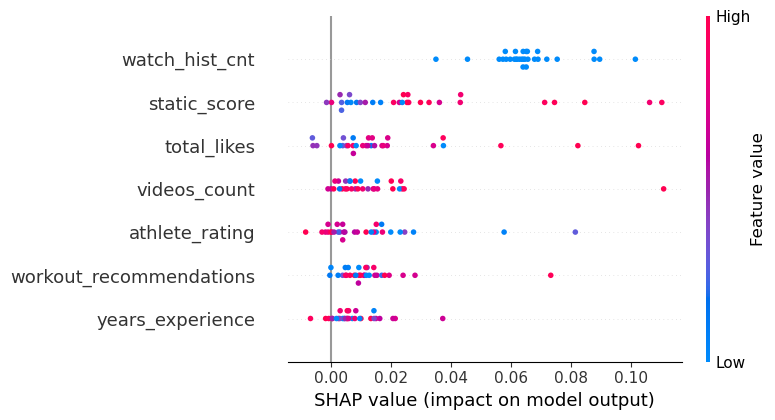

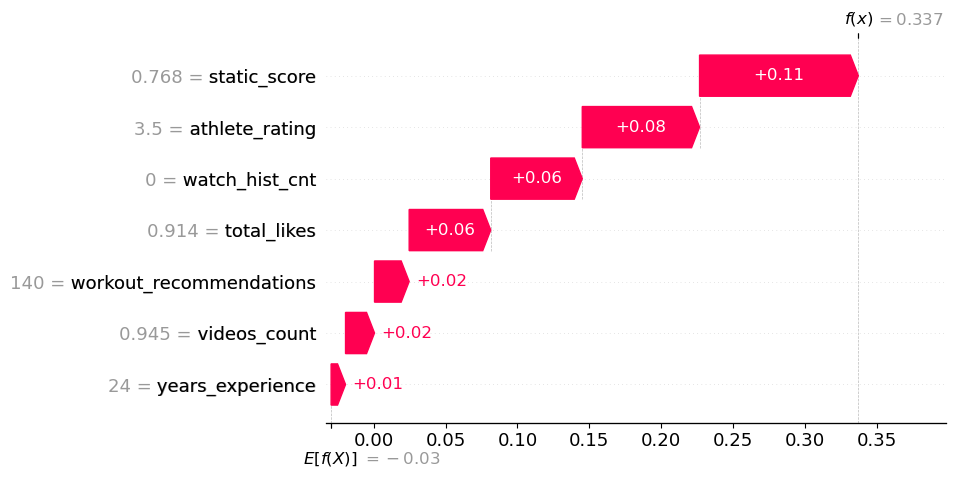

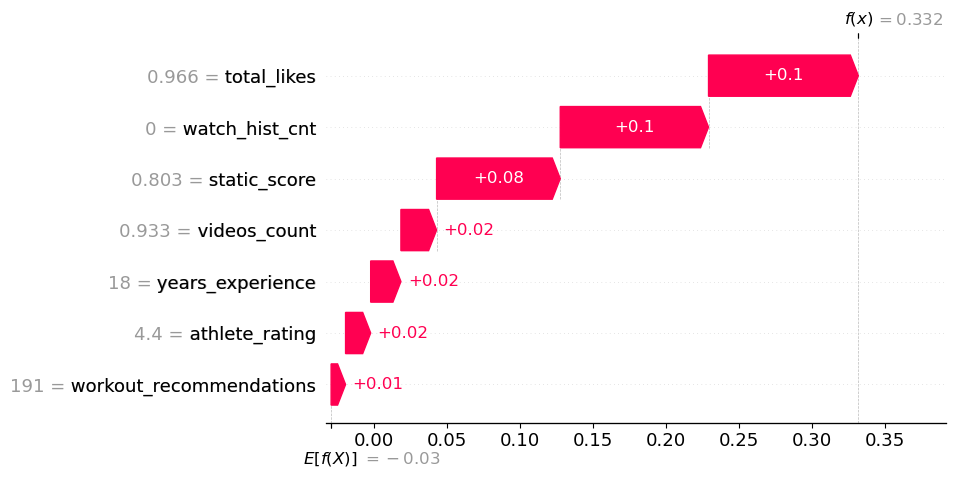

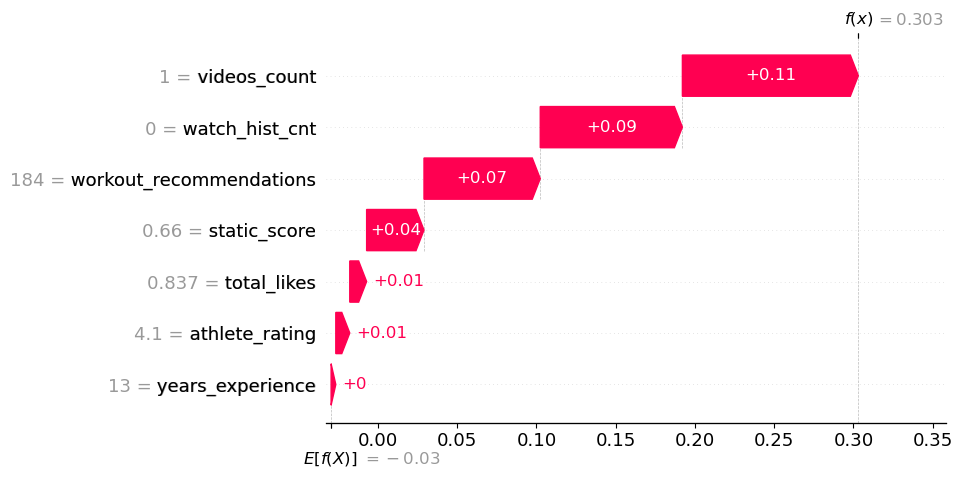

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Configuration & paths
PT_PATH    = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user_100000.csv"
MODEL_PATH = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_100000.txt"
USER_ID    = 10001
TOP_N      = 30
rng = np.random.default_rng(42)

# 2. Load & preprocess trainer static data
trainers = pd.read_csv(PT_PATH)
for col in [
    "athlete_rating",
    "total_likes",
    "workout_recommendations",
    "years_experience",
    "videos_count",
]:
    trainers[col] = pd.to_numeric(trainers[col], errors="coerce").fillna(0)
trainers["specialities"] = trainers["specialities"].astype(str)

# 3. Fit log1p + MinMaxScaler for count features
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[["total_likes"]]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[["videos_count"]]))

# 4. Build normalized columns for PCA
trainers["total_likes_norm"]  = scaler_likes.transform(np.log1p(trainers[["total_likes"]])).ravel()
trainers["videos_count_norm"] = scaler_videos.transform(np.log1p(trainers[["videos_count"]])).ravel()
for col in ["workout_recommendations", "athlete_rating", "years_experience"]:
    trainers[f"{col}_norm"] = MinMaxScaler().fit_transform(trainers[[col]]).ravel()

# 5. Compute static PCA score
pca_cols = [
    "total_likes_norm",
    "videos_count_norm",
    "workout_recommendations_norm",
    "athlete_rating_norm",
    "years_experience_norm",
]
pca = PCA(n_components=1).fit(trainers[pca_cols])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers["static_score"] = trainers[pca_cols].dot(w)

# 6. Load user history & build candidate pool
history = pd.read_csv(HIST_PATH)
user_hist = history[history["user_id"] == USER_ID].reset_index(drop=True)
if user_hist.empty:
    raise ValueError(f"No history for user_id={USER_ID}")
cands = trainers.copy()

# 7. Compute dynamic features (only direction_match & watch_hist_cnt)
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def direction_match(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    return int(bool(G & S))

goals = user_hist["user_goals"].iloc[0]
cands["direction_match"] = cands["specialities"].apply(lambda s: direction_match(goals, s))

watch_map = user_hist.groupby("trainer_id")["watched_count"].sum().to_dict()
cands["watch_hist_cnt"] = cands["trainer_id"].map(watch_map).fillna(0).astype(int)

# 8. Fill overlap_count & jaccard_score with zeros
cands["overlap_count"] = 0
cands["jaccard_score"] = 0

# 9. Re‑apply log1p + MinMax scaling to count features
cands["total_likes"]  = scaler_likes.transform(np.log1p(cands[["total_likes"]])).ravel()
cands["videos_count"] = scaler_videos.transform(np.log1p(cands[["videos_count"]])).ravel()

# 10. Load trained LambdaRank model
ranker = lgb.Booster(model_file=MODEL_PATH)

# 11. Define the full 10‑feature order
feature_cols = ranker.feature_name()
print("Model expects:", feature_cols)

# 12. Score & select top‑N
X = cands[feature_cols].values
cands["predicted_score"] = ranker.predict(X)
top30 = cands.nlargest(TOP_N, "predicted_score").reset_index(drop=True)

# 13. Prepare data for SHAP
X_explain = top30[feature_cols]
explainer = shap.TreeExplainer(ranker)
shap_values = explainer.shap_values(X_explain)

# 14. Remove overlap_count & jaccard_score from the summary plot
mask = [f for f in feature_cols if f not in ("overlap_count","jaccard_score")]
indices = [feature_cols.index(f) for f in mask]

plt.figure(figsize=(12, 8))
shap.summary_plot(
    np.array(shap_values)[:, indices],
    X_explain[mask],
    feature_names=mask,
    show=True,
    rng=rng
)

# 15. Waterfall for first three (also without those two)
for i in range(min(3, len(shap_values))):
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(
        shap.Explanation(
            values=np.array(shap_values[i])[indices],
            base_values=explainer.expected_value,
            data=X_explain[mask].iloc[i],
            feature_names=mask
        ),
        show=True
    )


### Example user 10002 - Top 30 Recommendations 

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# 1. Paths & parameters
PT_PATH    = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user_100000.csv"
MODEL_PATH = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_100000.txt"
USER_ID    = 10002
TOP_N      = 30

# 2. Load & preprocess trainer static data
trainers = pd.read_csv(PT_PATH)
for c in ["athlete_rating","total_likes","workout_recommendations","years_experience","videos_count"]:
    trainers[c] = pd.to_numeric(trainers[c], errors="coerce").fillna(0)
trainers["specialities"] = trainers["specialities"].astype(str)

# 3. Fit log1p + MinMaxScalers on count features
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[["total_likes"]]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[["videos_count"]]))

# 4. Build normalized columns for PCA
trainers["total_likes_norm"]  = scaler_likes.transform(np.log1p(trainers[["total_likes"]])).ravel()
trainers["videos_count_norm"] = scaler_videos.transform(np.log1p(trainers[["videos_count"]])).ravel()
for c in ["workout_recommendations","athlete_rating","years_experience"]:
    trainers[f"{c}_norm"] = MinMaxScaler().fit_transform(trainers[[c]]).ravel()

# 5. Compute static_score via PCA
pca_cols = [
    "total_likes_norm","videos_count_norm",
    "workout_recommendations_norm","athlete_rating_norm","years_experience_norm"
]
pca = PCA(n_components=1).fit(trainers[pca_cols])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers["static_score"] = trainers[pca_cols].dot(w)

# 6. Load user interaction history
history = pd.read_csv(HIST_PATH)
user_hist = history[history["user_id"]==USER_ID].reset_index(drop=True)
if user_hist.empty:
    raise ValueError(f"No history for user {USER_ID}")

# 7. Prepare full candidate pool
cands = trainers.copy()

# 8. Dynamic feature helpers
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_overlap(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    I, U = G & S, G | S
    return len(I), (len(I)/len(U) if U else 0.0), int(bool(I))

# 9. Compute overlap metrics
goals = user_hist["user_goals"].iloc[0]
ov = cands["specialities"].apply(lambda s: compute_overlap(goals, s)).tolist()
cands["overlap_count"]   = [t[0] for t in ov]
cands["jaccard_score"]   = [t[1] for t in ov]
cands["direction_match"] = [t[2] for t in ov]

# 10. Compute watch history count per trainer
watch_map = user_hist.groupby("trainer_id")["watched_count"].sum().to_dict()
cands["watch_hist_cnt"] = cands["trainer_id"].map(watch_map).fillna(0).astype(int)

# 11. Re‑apply exact count scaling (log1p + MinMax) for inference
cands["total_likes"]  = scaler_likes.transform(np.log1p(cands[["total_likes"]])).ravel()
cands["videos_count"] = scaler_videos.transform(np.log1p(cands[["videos_count"]])).ravel()

# 12. Load the LambdaRank model trained on these 10 features
ranker = lgb.Booster(model_file=MODEL_PATH)

# 13. Ensure feature order matches training
feature_cols = [
    "watch_hist_cnt",
    "athlete_rating","total_likes","videos_count",
    "workout_recommendations","years_experience","static_score"
]

# 14. Predict and normalize for composite score
cands["predicted_score"] = ranker.predict(cands[feature_cols].values)
cands["pred_norm"]       = MinMaxScaler().fit_transform(cands[["predicted_score"]])
cands["static_norm"]     = MinMaxScaler().fit_transform(cands[["static_score"]])
cands["composite_score"] = cands["pred_norm"] * 0.7 + cands["static_norm"] * 0.3

# 15. Output final Top‑N by composite_score
top30 = cands.nlargest(TOP_N, "composite_score")
print(
    top30[
        ["trainer_id","predicted_score","static_score","composite_score", "direction_match"]
    ].reset_index(drop=True)
)


    trainer_id  predicted_score  static_score  composite_score  \
0          619         0.331607      0.802570         0.944115   
1          550         0.337028      0.767531         0.940358   
2          128         0.286072      0.787420         0.867839   
3          438         0.290813      0.731182         0.855635   
4          191         0.303087      0.659810         0.849903   
5           83         0.255265      0.774565         0.815328   
6          134         0.146111      0.766878         0.642460   
7          105         0.100512      0.892357         0.615086   
8          947         0.107716      0.798304         0.593545   
9          885         0.086473      0.801048         0.561381   
10         106         0.062917      0.903876         0.560483   
11         826         0.091102      0.757743         0.553507   
12         977         0.082650      0.788302         0.550977   
13         739         0.074004      0.819566         0.548391   
14        

### Example user 10002 - Step by step recommendations 

In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Load and preprocess the full trainer dataset, computing a static score via PCA.
# Count features are log1p‑transformed and MinMax‑scaled, other numeric features are MinMax‑scaled.
pt_path = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
trainers = pd.read_csv(pt_path)
for col in ["athlete_rating", "total_likes", "workout_recommendations", "years_experience", "videos_count"]:
    trainers[col] = pd.to_numeric(trainers[col], errors="coerce").fillna(0)

# Fit scalers on the log‑transformed count features
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[["total_likes"]]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[["videos_count"]]))

# Replace raw counts with scaled log counts (keeping the original column names)
trainers["total_likes"]  = scaler_likes.transform(np.log1p(trainers[["total_likes"]]))
trainers["videos_count"] = scaler_videos.transform(np.log1p(trainers[["videos_count"]]))

# Scale the other numeric features
for col in ["workout_recommendations", "athlete_rating", "years_experience"]:
    trainers[col] = MinMaxScaler().fit_transform(trainers[[col]]).ravel()

# Compute a one‑dimensional PCA score over all normalized features
pca_features = ["total_likes", "videos_count", "workout_recommendations", "athlete_rating", "years_experience"]
pca = PCA(n_components=1).fit(trainers[pca_features])
weights = np.abs(pca.components_[0])
weights /= weights.sum()
trainers["static_score"] = trainers[pca_features].dot(weights)

trainers["specialities"] = trainers["specialities"].astype(str)

# Load user interaction history
hist_path    = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user_100000.csv"
user_history = pd.read_csv(hist_path)

def get_related_trainers(seen_ids, all_trainers, k):
    """Return up to k trainers sharing at least one speciality with any seen trainer."""
    spec_set = set()
    seen_df = all_trainers[all_trainers["trainer_id"].isin(seen_ids)]
    for specs in seen_df["specialities"].dropna():
        spec_set |= {s.strip().lower() for s in specs.split(",") if s.strip()}
    mask = all_trainers["specialities"].apply(
        lambda s: any(sp in s.lower().split(",") for sp in spec_set)
    )
    candidates = all_trainers[mask & ~all_trainers["trainer_id"].isin(seen_ids)]
    return candidates.nlargest(k, "static_score").reset_index(drop=True)

def stepwise_recommendations(user_id, history_df, trainers_df, model, feature_cols, top_n=15):
    """
    Simulate personalized recommendations after each user interaction.
    Overlap and jaccard features are omitted.
    """
    events = history_df[history_df["user_id"] == user_id].reset_index(drop=True)
    if events.empty:
        raise ValueError(f"No history for user_id={user_id}")

    seq = {}
    for step in range(1, len(events) + 1):
        prefix = events.iloc[:step]
        seen   = set(prefix["trainer_id"])

        related = get_related_trainers(seen, trainers_df, top_n)

        # build watch history count
        watch_map = prefix.groupby("trainer_id")["watched_count"].sum().to_dict()
        related["watch_hist_cnt"] = related["trainer_id"].map(watch_map).fillna(0).astype(int)

        # predict using the exact feature order
        X = related[feature_cols].values
        related["predicted_score"] = model.predict(X)

        seq[step] = related.nlargest(top_n, "predicted_score").reset_index(drop=True)

    return seq

if __name__ == "__main__":
    model_path = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_100000.txt"
    ranker = lgb.Booster(model_file=model_path)

    # These must exactly match the names and order used during training
    feature_cols = [
        "watch_hist_cnt",
        "athlete_rating",
        "total_likes",
        "videos_count",
        "workout_recommendations",
        "years_experience",
        "static_score",
    ]

    results = stepwise_recommendations(
        user_id      = 10002,
        history_df   = user_history,
        trainers_df  = trainers,
        model        = ranker,
        feature_cols = feature_cols,
        top_n        = 18
    )

    for step, df in results.items():
        print(f"\nAfter interaction {step}:")
        print(df[["trainer_id", "predicted_score"]].to_string(index=False))



After interaction 1:
 trainer_id  predicted_score
        833         0.191946
        579         0.186719
        558         0.180326
         52         0.174251
        534         0.167757
        257         0.155135
        331         0.147747
        953         0.141401
        923         0.134334
        915         0.124219
        303         0.112057
        845         0.074260
        363         0.070757
        181         0.066924
         37         0.063472
        867         0.053628
        974         0.027265
        420         0.023083

After interaction 2:
 trainer_id  predicted_score
        555         0.279253
        998         0.270863
        147         0.256934
        234         0.183037
        558         0.180326
        965         0.173655
        748         0.170456
          1         0.165270
        499         0.155597
        677         0.152825
        486         0.149041
        598         0.135484
        448         0.131550

### Example user 10002 - Rank metrix based on LambdaRank

In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

def load_trainers(pt_path):
    """
    Load trainer data and compute static_score via PCA.
    Count features are log1p-transformed and MinMax-scaled (overwriting the original columns),
    other numeric features are MinMax-scaled independently,
    then collapsed into a single static_score.
    """
    df = pd.read_csv(pt_path)
    for col in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # fit scalers on log1p(counts)
    scaler_likes  = MinMaxScaler().fit(np.log1p(df[['total_likes']]))
    scaler_videos = MinMaxScaler().fit(np.log1p(df[['videos_count']]))

    # overwrite with scaled log counts
    df['total_likes']  = scaler_likes.transform(np.log1p(df[['total_likes']])).ravel()
    df['videos_count'] = scaler_videos.transform(np.log1p(df[['videos_count']])).ravel()

    # scale remaining numeric features
    for c in ['workout_recommendations','athlete_rating','years_experience']:
        df[c] = MinMaxScaler().fit_transform(df[[c]]).ravel()

    # compute static_score via PCA over all five normalized columns
    pca_cols = ['total_likes','videos_count','workout_recommendations','athlete_rating','years_experience']
    pca = PCA(n_components=1).fit(df[pca_cols])
    w = np.abs(pca.components_[0])
    w /= w.sum()
    df['static_score'] = df[pca_cols].dot(w)

    df['specialities'] = df['specialities'].astype(str)
    return df, scaler_likes, scaler_videos

def tokenize(text):
    """Split comma/semicolon-separated string into lowercase tokens."""
    return {tok.strip().lower() for tok in re.split(r'[,;/、]', text) if tok.strip()}

def get_related_trainers(seen_ids, trainers_df, k):
    """
    Given a set of seen trainer_ids, return the top‐k others
    sharing at least one speciality, ranked by static_score.
    """
    spec_set = set()
    subset = trainers_df[trainers_df['trainer_id'].isin(seen_ids)]
    for specs in subset['specialities'].dropna():
        spec_set |= tokenize(specs)
    mask = trainers_df['specialities'].apply(lambda s: bool(spec_set & tokenize(s)))
    cands = trainers_df[mask & ~trainers_df['trainer_id'].isin(seen_ids)]
    return cands.nlargest(k, 'static_score').reset_index(drop=True)

def stepwise_recommendations(user_id, history_df, trainers_df, model,
                             scaler_likes, scaler_videos, feature_cols, top_n=30):
    """
    Simulate recommendations after each interaction.
    Uses only watch_hist_cnt + static features.
    """
    events = history_df[history_df['user_id']==user_id].reset_index(drop=True)
    if events.empty:
        raise ValueError(f"No history for user_id={user_id}")

    seq = {}
    for step in range(1, len(events)+1):
        prefix = events.iloc[:step]
        seen   = set(prefix['trainer_id'])

        related = get_related_trainers(seen, trainers_df, top_n)

        # build historical watch count
        watch_map = prefix.groupby('trainer_id')['watched_count'].sum().to_dict()
        related['watch_hist_cnt'] = related['trainer_id'].map(watch_map).fillna(0).astype(int)

        # predict with same feature names as training
        X = related[feature_cols].values
        related['predicted_score'] = model.predict(X)

        seq[step] = related.nlargest(top_n, 'predicted_score').reset_index(drop=True)

    return seq

def build_rank_matrix(seq):
    """
    Convert stepwise recommendation outputs into a rank matrix:
    rows are trainer_id, columns are step indices, values are rank positions.
    """
    all_ids = sorted({tid for df in seq.values() for tid in df['trainer_id']})
    steps   = sorted(seq.keys())
    cols    = [f"step_{s}" for s in steps]
    mat = pd.DataFrame(index=all_ids, columns=cols, dtype=float)

    for s in steps:
        order = list(seq[s]['trainer_id'])
        for tid in all_ids:
            mat.at[tid, f"step_{s}"] = (order.index(tid)+1) if tid in order else np.nan

    return mat

if __name__ == '__main__':
    PT_PATH    = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
    trainers_df, scaler_likes, scaler_videos = load_trainers(PT_PATH)

    HIST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user_100000.csv"
    history_df = pd.read_csv(HIST_PATH)

    MODEL_PATH = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_100000.txt"
    model = lgb.Booster(model_file=MODEL_PATH)

    # feature names must exactly match training
    feature_cols = [
        'watch_hist_cnt',
        'athlete_rating',
        'total_likes',
        'videos_count',
        'workout_recommendations',
        'years_experience',
        'static_score'
    ]

    seq = stepwise_recommendations(
        user_id       = 10002,
        history_df    = history_df,
        trainers_df   = trainers_df,
        model         = model,
        scaler_likes  = scaler_likes,
        scaler_videos = scaler_videos,
        feature_cols  = feature_cols,
        top_n         = 18
    )

    rank_matrix = build_rank_matrix(seq)
    print("Rank matrix for each interaction step:")
    print(rank_matrix)


Rank matrix for each interaction step:
     step_1  step_2  step_3  step_4  step_5  step_6  step_7  step_8  step_9  \
6       5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0   
82      8.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
105     3.0     4.0     4.0     4.0     4.0     4.0     4.0     4.0     4.0   
106     NaN     NaN     NaN    13.0    13.0    14.0    14.0    14.0    14.0   
118     NaN    10.0     9.0    10.0    10.0    10.0     9.0     9.0     9.0   
128     1.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
147     2.0     3.0     3.0     3.0     3.0     3.0     3.0     3.0     3.0   
174     NaN     NaN     NaN     NaN    15.0    16.0    16.0    16.0    16.0   
234     NaN     6.0     6.0     7.0     7.0     7.0     6.0     6.0     6.0   
271     NaN    13.0    12.0     NaN     NaN     NaN     NaN     NaN     NaN   
290     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN    18.0   
303    18.0  

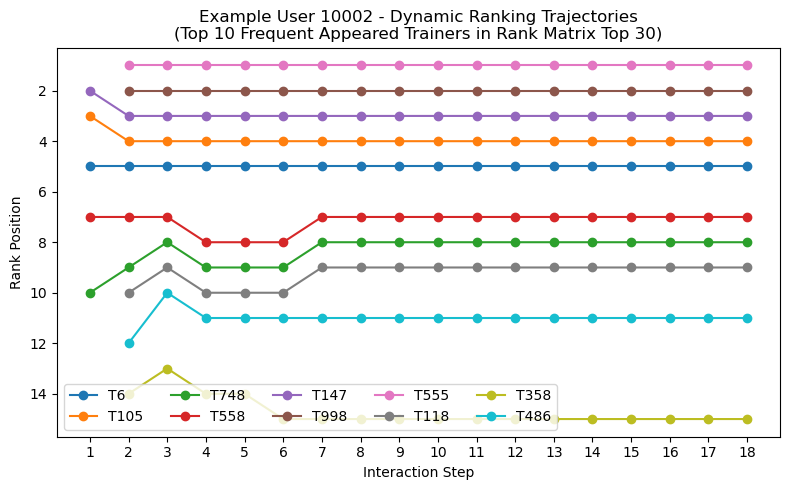

In [8]:
import matplotlib.pyplot as plt
# Visualization of top 10 ranking changes of user 10002
freq = rank_matrix.notna().sum(axis=1)
top10 = freq.sort_values(ascending=False).head(10).index

plt.figure(figsize=(8,5))
for tid in top10:
    ys = rank_matrix.loc[tid, [f"step_{i}" for i in sorted(seq.keys())]]
    plt.plot(sorted(seq.keys()), ys, marker='o', label=f"T{tid}")
plt.gca().invert_yaxis()
plt.xticks(sorted(seq.keys()))
plt.xlabel("Interaction Step")
plt.ylabel("Rank Position")
plt.title(f"Example User 10002 - Dynamic Ranking Trajectories\n(Top 10 Frequent Appeared Trainers in Rank Matrix Top 30)")
plt.legend(ncol=5, loc='lower left')
plt.tight_layout()
# plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/Dynamic Ranking Trajectories(Top 10 Frequent Appeared Trainers in Rank Matrix Top 30).png")  # Save to file
plt.show()

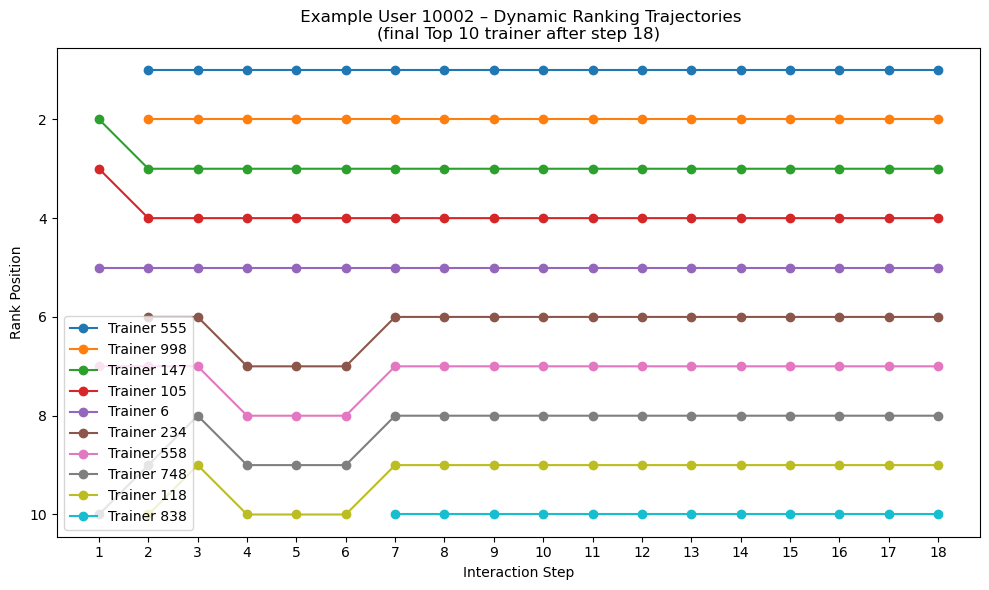


Final Top10 after step 18:
 trainer_id  predicted_score
        555         0.279253
        998         0.270863
        147         0.256934
        105         0.200112
          6         0.192034
        234         0.183037
        558         0.180326
        748         0.170456
        118         0.162594
        838         0.162262


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the Top 10 after all interactions are completed
last_step = max(seq.keys())
final_df  = seq[last_step].reset_index(drop=True)
top10_ids = final_df['trainer_id'].head(10).astype(str).tolist()

# Construct a rank_matrix: the rows are the 10 trainers, the columns are each step, and the values are their ranking positions at that step
steps       = sorted(seq.keys())
rank_matrix = pd.DataFrame(index=top10_ids, columns=steps, dtype=float)

for step in steps:
    df_step = seq[step]
    ids     = df_step['trainer_id'].astype(str).tolist()
    for tid in top10_ids:
        if tid in ids:
            rank_matrix.at[tid, step] = ids.index(tid) + 1
        else:
            rank_matrix.at[tid, step] = np.nan

# Visualisation: A line graph showing the ranking trajectory of the Final Top 10 trainer recommanded 
plt.figure(figsize=(10, 6))
for tid in top10_ids:
    plt.plot(
        steps,
        rank_matrix.loc[tid],
        marker='o',
        label=f'Trainer {tid}'
    )

plt.gca().invert_yaxis()           
plt.xticks(steps)                  
plt.xlabel("Interaction Step")   
plt.ylabel("Rank Position")  
plt.title(f" Example User 10002 – Dynamic Ranking Trajectories\n(final Top 10 trainer after step {last_step})")
plt.legend(loc="lower left", ncol=1)
plt.tight_layout()
# plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/Dynamic Ranking Trajectories(final Top 10 trainer after step 18.png")  # Save to file
plt.show()

print(f"\nFinal Top10 after step {last_step}:")
print(final_df[['trainer_id', 'predicted_score']].head(10).to_string(index=False))
